# Uploading files to collab

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from skopt import BayesSearchCV
from sklearn.neighbors import KNeighborsRegressor
from skopt.space import Integer, Real, Categorical
from sklearn.utils.class_weight import compute_sample_weight
import shap
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# ML

## 1. Preparation

### 1.1. Working with the table

In [2]:
db_2 = pd.read_excel('data_for_ML_unn_for_class.xlsx')
db_1 = db_2.drop(columns=['Wine_strength'])
db_1.insert(50, 'Wine_strength', db_2['Wine_strength'])
db_final = db_1.drop(columns=['Sugar_encoded'])
db_final.insert(0, 'Sugar_encoded', db_1['Sugar_encoded'])

In [3]:
colors = ['#a5678e','#e8b7d4', '#beb7d9', '#7eabd4', '#31539d']

In [4]:
db_final.describe()

,Sugar_encoded,1_vec_1,1_vec_2,1_vec_3,1_vec_4,1_vec_5,1_vec_6,1_vec_7,1_vec_8,1_vec_9,...,4_vec_8,4_vec_9,4_vec_10,%_4,Harvest_year,Color_Orange,Color_Pink,Color_Red,Color_White,Wine_strength
count,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,...,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.00000,14389.000000
mean,1.167837,0.060454,0.018292,0.079030,0.038532,0.019369,0.091676,0.173179,0.058107,-0.077239,...,0.005718,-0.003516,0.002559,0.002489,0.597499,0.003405,0.045521,0.551393,0.39968,2.548753
std,0.700276,0.253451,0.277256,0.367961,0.269708,0.334826,0.312388,0.321148,0.300864,0.304123,...,0.061957,0.049046,0.060644,0.020515,0.442962,0.058258,0.208451,0.497369,0.48985,0.669392
min,0.000000,-0.626064,-0.638262,-0.626405,-0.666614,-0.582963,-0.613744,-0.686419,-0.579507,-0.636982,...,-0.579029,-0.636982,-0.553962,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,1.000000,-0.093300,-0.179822,-0.322336,-0.146991,-0.297306,-0.223522,-0.115570,-0.241545,-0.339760,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.000000
50%,1.000000,0.096905,-0.037406,0.191290,-0.010493,0.071893,0.128300,0.310806,0.160546,-0.150012,...,0.000000,0.000000,0.000000,0.000000,0.887324,0.000000,0.000000,1.000000,0.00000,3.000000
75%,1.000000,0.257025,0.285380,0.427216,0.150550,0.328234,0.405705,0.433208,0.276289,0.099057,...,0.000000,0.000000,0.000000,0.000000,0.957746,0.000000,0.000000,1.000000,1.00000,3.000000
max,4.000000,0.687540,0.629917,0.807477,0.717936,0.611457,0.630208,0.669380,0.683798,0.613503,...,0.502610,0.545916,0.516585,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,4.000000


### 1.2. Splitting data into test and train

In [5]:
def separation(x,y,n_splits,test_size):
    separation = []
    k_fold = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42)
    for train_idx, test_idx in k_fold.split(x, y):
        separation.append((train_idx, test_idx))
    return separation

In [6]:
y = db_final.loc[:,'Wine_strength']
x = db_final.loc[:,'1_vec_1':]
cv = separation(x, y, 1, 0.2)
for train_idx, val_idx in cv:
    x_train, x_test = x.iloc[train_idx], x.iloc[val_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[val_idx]

### 1.3. Functions for plotting and calculating metrics

In [7]:
def metrics(regr, x_train, y_train, y_test, y_pred, y1_pred):
    F1 = f1_score(y_test, y_pred, average='micro')
    F1_train = f1_score(y_train, y1_pred, average='micro')
    Accuracy = balanced_accuracy_score(y_test, y_pred)
    Accuracy_train = balanced_accuracy_score(y_train, y1_pred)

    print('f1_score:', F1)
    print('Accuracy:', Accuracy)
    print('f1_train:', F1_train)
    print('Accuracy_train:', Accuracy_train)
    return [F1_train, F1, Accuracy_train, Accuracy]

## 2. Random Forest Classification

In [10]:
class_RFC = RandomForestClassifier()

search_space = {"n_estimators": Integer(50,400),
    "criterion": Categorical(['entropy']),
    "min_samples_split": Real(0.01, 0.6),
    "min_samples_leaf": Real(0.01, 0.5),
    "max_depth": Integer(1, 12),
    "max_features": Integer(3, 24)}

df_error_train = pd.DataFrame()
x_model = x_train.copy().drop(['Wine_strength'],axis=1)

y_model = y_train.copy()
cv = separation(x_model, y_model, 5, 0.2)
count = 0

sc = MinMaxScaler(feature_range=(0, 1))
x_train01 = sc.fit_transform(x_model)
opt_RFC = BayesSearchCV(estimator = class_RFC, search_spaces=search_space, cv = separation(x_model, y_model, 5, 0.2), n_iter=32, verbose=2, n_jobs=-1)
opt_RFC.fit(x_train01, y_model)

n_esti = opt_RFC.best_estimator_.n_estimators
criterion = opt_RFC.best_estimator_.criterion
min_leaf = opt_RFC.best_estimator_.min_samples_leaf
min_split = opt_RFC.best_estimator_.min_samples_split
depth = opt_RFC.best_estimator_.max_depth
max_feat = opt_RFC.best_estimator_.max_features

print('n_esti:', n_esti,'depth:', depth, 'criterion:', criterion, 'min_leaf:', min_leaf,'min_split:', min_split,'max_feat:', max_feat)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END criterion=entropy, max_depth=7, max_features=19, min_samples_leaf=0.07759017742813529, min_samples_split=0.30190391618466733, n_estimators=315; total time=   9.2s
[CV] END criterion=entropy, max_depth=7, max_features=19, min_samples_leaf=0.07759017742813529, min_samples_split=0.30190391618466733, n_estimators=315; total time=   9.1s
[CV] END criterion=entropy, max_depth=7, max_features=19, min_samples_leaf=0.07759017742813529, min_samples_split=0.30190391618466733, n_estimators=315; total time=   9.3s
[CV] END criterion=entropy, max_depth=7, max_features=19, min_samples_leaf=0.07759017742813529, min_samples_split=0.30190391618466733, n_estimators=315; total time=   9.4s
[CV] END criterion=entropy, max_depth=7, max_features=19, min_samples_leaf=0.07759017742813529, min_samples_split=0.30190391618466733, n_estimators=315; total time=   4.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END criterion=ent

In [11]:
count = 0

RFC_df = x_model[:]
RFC_df['Strength'] = y_model

for train_idx, val_idx in cv:
    x_train_mod, x_test_mod = x_model.iloc[train_idx], x_model.iloc[val_idx]
    y_train_mod, y_test_mod = y_model.iloc[train_idx], y_model.iloc[val_idx]

    sc = MinMaxScaler(feature_range=(0, 1))
    x_train_mod = sc.fit_transform(x_train_mod)
    x_test_mod = sc.transform(x_test_mod)

    regr_RFC = RandomForestClassifier(n_estimators=n_esti, max_depth=depth, min_samples_leaf=min_leaf,
                                 min_samples_split=min_split, criterion=criterion, max_features=max_feat)
    regr_RFC.fit(x_train_mod, y_train_mod)
    y_pred = regr_RFC.predict(x_test_mod)
    y1_pred = regr_RFC.predict(x_train_mod)

    RFC_df['Strength_train' + str(count)] = None
    RFC_df['Strength_test' + str(count)] = None
    RFC_df['Strength_train' + str(count)].iloc[train_idx] = y1_pred
    RFC_df['Strength_test' + str(count)].iloc[val_idx] = y_pred

    df_error_train['Random Forest Classification' + str(count)] = metrics(regr_RFC, x_train_mod, y_train_mod, y_test_mod, y_pred, y1_pred)
    count +=1
df_error_train


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



f1_score: 0.6691272253582284
Accuracy: 0.2917091368001391
f1_train: 0.6734361424847958
Accuracy_train: 0.2947022347949081



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


f1_score: 0.6621797655232305
Accuracy: 0.2895304815291141
f1_train: 0.6740877497827976
Accuracy_train: 0.29488499903927845



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


f1_score: 0.6695614415979158
Accuracy: 0.2917014759120022
f1_train: 0.6678974804517811
Accuracy_train: 0.2931804363230414



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


f1_score: 0.6508901432913591
Accuracy: 0.28499061506580303
f1_train: 0.6718071242397915
Accuracy_train: 0.29381155566474704
f1_score: 0.6634824142422927
Accuracy: 0.29034421888790823
f1_train: 0.6671372719374457
Accuracy_train: 0.2924841370156795



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Random Forest Classification0,Random Forest Classification1,Random Forest Classification2,Random Forest Classification3,Random Forest Classification4
0,0.673436,0.674088,0.667897,0.671807,0.667137
1,0.669127,0.662180,0.669561,0.650890,0.663482
2,0.294702,0.294885,0.293180,0.293812,0.292484
3,0.291709,0.289530,0.291701,0.284991,0.290344


## 3. Gradient Boosting Classification

In [10]:
df_error_train = pd.DataFrame()
x_model = x_train.copy().drop(['Wine_strength'],axis=1)

y_model = y_train.copy()
cv = separation(x_model, y_model, 5, 0.2)
count = 0

class_GBC = GradientBoostingClassifier()

search_space = {"learning_rate": Real(0.05, 0.15),
    "n_estimators": Integer(50, 400),
    "max_depth": Integer(1, 6),
    "min_samples_leaf": Real(0.05, 0.5),
    "min_samples_split": Real(0.02, 0.6)}

sc = MinMaxScaler(feature_range=(0, 1))
x_train01 = sc.fit_transform(x_model)

opt_GBC = BayesSearchCV(estimator = class_GBC, search_spaces=search_space, cv=separation(x_model, y_model,5, 0.2), n_iter=32, verbose=2, n_jobs=-1)
opt_GBC.fit(x_train01, y_model)

learning_rate = opt_GBC.best_estimator_.learning_rate
n_estimators = opt_GBC.best_estimator_.n_estimators
max_depth = opt_GBC.best_estimator_.max_depth
min_samples_leaf = opt_GBC.best_estimator_.min_samples_leaf
min_samples_split = opt_GBC.best_estimator_.min_samples_split

print('learning_rate:', learning_rate,'n_estimators:', n_estimators, 'max_depth:', max_depth, 'min_samples_leaf:', min_samples_leaf,'min_samples_split:', min_samples_split)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.13831266527911606, max_depth=5, min_samples_leaf=0.4704450133554539, min_samples_split=0.5696657854364918, n_estimators=58; total time=  11.7s
[CV] END learning_rate=0.13831266527911606, max_depth=5, min_samples_leaf=0.4704450133554539, min_samples_split=0.5696657854364918, n_estimators=58; total time=  11.7s
[CV] END learning_rate=0.13831266527911606, max_depth=5, min_samples_leaf=0.4704450133554539, min_samples_split=0.5696657854364918, n_estimators=58; total time=  11.8s
[CV] END learning_rate=0.13831266527911606, max_depth=5, min_samples_leaf=0.4704450133554539, min_samples_split=0.5696657854364918, n_estimators=58; total time=  12.0s
[CV] END learning_rate=0.13831266527911606, max_depth=5, min_samples_leaf=0.4704450133554539, min_samples_split=0.5696657854364918, n_estimators=58; total time=   4.9s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.0768746957126654,

The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.15, max_depth=6, min_samples_leaf=0.05, min_samples_split=0.02, n_estimators=400; total time= 4.5min
[CV] END learning_rate=0.15, max_depth=6, min_samples_leaf=0.05, min_samples_split=0.02, n_estimators=400; total time= 4.6min
[CV] END learning_rate=0.15, max_depth=6, min_samples_leaf=0.05, min_samples_split=0.02, n_estimators=400; total time= 4.6min
[CV] END learning_rate=0.15, max_depth=6, min_samples_leaf=0.05, min_samples_split=0.02, n_estimators=400; total time= 4.6min
[CV] END learning_rate=0.15, max_depth=6, min_samples_leaf=0.05, min_samples_split=0.02, n_estimators=400; total time= 1.6min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.1282567428821437, max_depth=6, min_samples_leaf=0.17788496961245143, min_samples_split=0.023231421809895646, n_estimators=340; total time= 1.9min
[CV] END learning_rate=0.1282567428821437, max_depth=6, min_samples_leaf=0.177884

The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.15, max_depth=6, min_samples_leaf=0.05, min_samples_split=0.02, n_estimators=400; total time= 4.7min
[CV] END learning_rate=0.15, max_depth=6, min_samples_leaf=0.05, min_samples_split=0.02, n_estimators=400; total time= 4.7min
[CV] END learning_rate=0.15, max_depth=6, min_samples_leaf=0.05, min_samples_split=0.02, n_estimators=400; total time= 4.7min
[CV] END learning_rate=0.15, max_depth=6, min_samples_leaf=0.05, min_samples_split=0.02, n_estimators=400; total time= 4.8min
[CV] END learning_rate=0.15, max_depth=6, min_samples_leaf=0.05, min_samples_split=0.02, n_estimators=400; total time= 1.6min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.15, max_depth=6, min_samples_leaf=0.13584833190465406, min_samples_split=0.02, n_estimators=400; total time= 4.2min
[CV] END learning_rate=0.15, max_depth=6, min_samples_leaf=0.13584833190465406, min_samples_split=0.02, n_estim

In [11]:
count = 0
GBC_df = x_model[:]
GBC_df['Sugar'] = y_model

for train_idx, val_idx in cv:
    x_train_mod, x_test_mod = x_model.iloc[train_idx], x_model.iloc[val_idx]
    y_train_mod, y_test_mod = y_model.iloc[train_idx], y_model.iloc[val_idx]

    sc = MinMaxScaler(feature_range=(0, 1))
    x_train_mod = sc.fit_transform(x_train_mod)
    x_test_mod = sc.transform(x_test_mod)

    class_GBC = GradientBoostingClassifier(learning_rate = learning_rate, n_estimators = n_estimators, max_depth= max_depth, min_samples_leaf= min_samples_leaf, min_samples_split= min_samples_split)
    class_GBC.fit(x_train_mod, y_train_mod)
    y_pred = class_GBC.predict(x_test_mod)
    y1_pred = class_GBC.predict(x_train_mod)

    GBC_df['Strength_train' + str(count)] = None
    GBC_df['Strength_test' + str(count)] = None
    GBC_df['Strength_train' + str(count)].iloc[train_idx] = y1_pred
    GBC_df['Strength_test' + str(count)].iloc[val_idx] = y_pred

    df_error_train['Gradient Boosting Classification' + str(count)] = metrics(class_GBC, x_train_mod, y_train_mod, y_test_mod, y_pred, y1_pred)
    count +=1
df_error_train


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



f1_score: 0.6973512809379071
Accuracy: 0.4599371505272388
f1_train: 0.7578192875760209
Accuracy_train: 0.576678657138885



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


f1_score: 0.6951801997394702
Accuracy: 0.46878697544083286
f1_train: 0.7611859252823632
Accuracy_train: 0.5845390395856279



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


f1_score: 0.7129830655666523
Accuracy: 0.4428645256912045
f1_train: 0.7572762814943529
Accuracy_train: 0.5891734945108346



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


f1_score: 0.6973512809379071
Accuracy: 0.47650294567587803
f1_train: 0.7573848827106864
Accuracy_train: 0.578194577653244



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


f1_score: 0.6990881458966566
Accuracy: 0.46551770854669733
f1_train: 0.7602085143353605
Accuracy_train: 0.5779805280427828


,Gradient Boosting Classification0,Gradient Boosting Classification1,Gradient Boosting Classification2,Gradient Boosting Classification3,Gradient Boosting Classification4
0,0.757819,0.761186,0.757276,0.757385,0.760209
1,0.697351,0.695180,0.712983,0.697351,0.699088
2,0.576679,0.584539,0.589173,0.578195,0.577981
3,0.459937,0.468787,0.442865,0.476503,0.465518


## 4. Extreme Gradient Boosting (XGBoost)

In [15]:
class_XGB = XGBClassifier()

search_space = {"n_estimators": Integer(50, 350),
    "max_depth": Integer(2, 30),
    "subsample": Real(0.05, 1.0),
    "colsample_bytree": Real(0.05, 1.0)}

sc = MinMaxScaler(feature_range=(0, 1))
x_train01 = sc.fit_transform(x_model)
opt_XGB = BayesSearchCV(estimator = class_XGB, search_spaces=search_space, cv = separation(x_model, y_model, 5, 0.2), n_iter=32, verbose=2, n_jobs=-1)
opt_XGB.fit(x_train01, y_model)

n_estimators = opt_XGB.best_estimator_.n_estimators
max_depth = opt_XGB.best_estimator_.max_depth
subsample = opt_XGB.best_estimator_.subsample
colsample_bytree = opt_XGB.best_estimator_.colsample_bytree

print('n_estimators:', n_estimators,'max_depth:', max_depth, 'subsample:', subsample,'colsample_bytree:', colsample_bytree)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END colsample_bytree=0.631238489676593, max_depth=19, n_estimators=230, subsample=0.34141914849869864; total time=  32.8s
[CV] END colsample_bytree=0.631238489676593, max_depth=19, n_estimators=230, subsample=0.34141914849869864; total time=  33.0s
[CV] END colsample_bytree=0.631238489676593, max_depth=19, n_estimators=230, subsample=0.34141914849869864; total time=  33.1s
[CV] END colsample_bytree=0.631238489676593, max_depth=19, n_estimators=230, subsample=0.34141914849869864; total time=  33.0s
[CV] END colsample_bytree=0.631238489676593, max_depth=19, n_estimators=230, subsample=0.34141914849869864; total time=  11.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END colsample_bytree=0.5392478640826195, max_depth=4, n_estimators=236, subsample=0.33627810759935595; total time=   5.6s
[CV] END colsample_bytree=0.5392478640826195, max_depth=4, n_estimators=236, subsample=0.33627810759935595; total time= 

In [16]:
count = 0
XGB_df = x_model[:]
XGB_df['Sugar'] = y_model

for train_idx, val_idx in cv:
    x_train_mod, x_test_mod = x_model.iloc[train_idx], x_model.iloc[val_idx]
    y_train_mod, y_test_mod = y_model.iloc[train_idx], y_model.iloc[val_idx]

    sc = MinMaxScaler(feature_range=(0, 1))
    x_train_mod = sc.fit_transform(x_train_mod)
    x_test_mod = sc.transform(x_test_mod)

    class_XGB = XGBClassifier(n_estimators = n_estimators, max_depth = max_depth, subsample = subsample, colsample_bytree = colsample_bytree)
    class_XGB.fit(x_train_mod, y_train_mod)
    y_pred = class_XGB.predict(x_test_mod)
    y1_pred = class_XGB.predict(x_train_mod)

    XGB_df['Strength_train' + str(count)] = None
    XGB_df['Strength_test' + str(count)] = None
    XGB_df['Strength_train' + str(count)].iloc[train_idx] = y1_pred
    XGB_df['Strength_test' + str(count)].iloc[val_idx] = y_pred

    df_error_train['XGBoosting Classification' + str(count)] = metrics(class_XGB, x_train_mod, y_train_mod, y_test_mod, y_pred, y1_pred)
    count +=1
df_error_train


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



f1_score: 0.7021276595744681
Accuracy: 0.4396628590947828
f1_train: 0.7409860990443095
Accuracy_train: 0.5070641382646615



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


f1_score: 0.6977854971775944
Accuracy: 0.46367584295261866
f1_train: 0.7427237185056473
Accuracy_train: 0.5074586848809072



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


f1_score: 0.7121146330872775
Accuracy: 0.40727610251203716
f1_train: 0.7394656820156386
Accuracy_train: 0.5176563619833441



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


f1_score: 0.6990881458966566
Accuracy: 0.4437308097082533
f1_train: 0.7408774978279756
Accuracy_train: 0.5006043573509763
f1_score: 0.6999565783760313
Accuracy: 0.4509235563041122
f1_train: 0.7404430929626411
Accuracy_train: 0.5018232806440538



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Random Forest Classification0,Random Forest Classification1,Random Forest Classification2,Random Forest Classification3,Random Forest Classification4,Gradient Boosting Classification0,Gradient Boosting Classification1,Gradient Boosting Classification2,Gradient Boosting Classification3,Gradient Boosting Classification4,XGBoosting Classification0,XGBoosting Classification1,XGBoosting Classification2,XGBoosting Classification3,XGBoosting Classification4
0,0.673436,0.674088,0.667897,0.671807,0.667137,0.757819,0.761186,0.757276,0.757385,0.760209,0.740986,0.742724,0.739466,0.740877,0.740443
1,0.669127,0.662180,0.669561,0.650890,0.663482,0.697351,0.695180,0.712983,0.697351,0.699088,0.702128,0.697785,0.712115,0.699088,0.699957
2,0.294702,0.294885,0.293180,0.293812,0.292484,0.576679,0.584539,0.589173,0.578195,0.577981,0.507064,0.507459,0.517656,0.500604,0.501823
3,0.291709,0.289530,0.291701,0.284991,0.290344,0.459937,0.468787,0.442865,0.476503,0.465518,0.439663,0.463676,0.407276,0.443731,0.450924


## 5. General graphs

In [17]:
df_error_train.index = ['F1_train', 'F1_test', 'Accuracy_train', 'Accuracy_test']
df_error_train

,Random Forest Classification0,Random Forest Classification1,Random Forest Classification2,Random Forest Classification3,Random Forest Classification4,Gradient Boosting Classification0,Gradient Boosting Classification1,Gradient Boosting Classification2,Gradient Boosting Classification3,Gradient Boosting Classification4,XGBoosting Classification0,XGBoosting Classification1,XGBoosting Classification2,XGBoosting Classification3,XGBoosting Classification4
F1_train,0.673436,0.674088,0.667897,0.671807,0.667137,0.757819,0.761186,0.757276,0.757385,0.760209,0.740986,0.742724,0.739466,0.740877,0.740443
F1_test,0.669127,0.662180,0.669561,0.650890,0.663482,0.697351,0.695180,0.712983,0.697351,0.699088,0.702128,0.697785,0.712115,0.699088,0.699957
Accuracy_train,0.294702,0.294885,0.293180,0.293812,0.292484,0.576679,0.584539,0.589173,0.578195,0.577981,0.507064,0.507459,0.517656,0.500604,0.501823
Accuracy_test,0.291709,0.289530,0.291701,0.284991,0.290344,0.459937,0.468787,0.442865,0.476503,0.465518,0.439663,0.463676,0.407276,0.443731,0.450924


In [18]:
df_error_train_1 = df_error_train.transpose()
f_get_name = lambda x: x[:-1]
df_error_train_1['Class'] = df_error_train_1.index
df_error_train_1['Class'] = df_error_train_1['Class'].apply(f_get_name)
df_error_train_1 = df_error_train_1.groupby('Class').agg(['mean', 'std'])
df_error_train_1.columns = ['_'.join(col).rstrip('_') for col in df_error_train_1.columns.values] 
df_error_train_1

,F1_train_mean,F1_train_std,F1_test_mean,F1_test_std,Accuracy_train_mean,Accuracy_train_std,Accuracy_test_mean,Accuracy_test_std
Class,,,,,,,,
Gradient Boosting Classification,0.758775,0.001800,0.700391,0.007174,0.581313,0.005350,0.462722,0.012615
Random Forest Classification,0.670873,0.003185,0.663048,0.007552,0.293813,0.001013,0.289655,0.002768
XGBoosting Classification,0.740899,0.001183,0.702215,0.005756,0.506921,0.006735,0.441054,0.020971


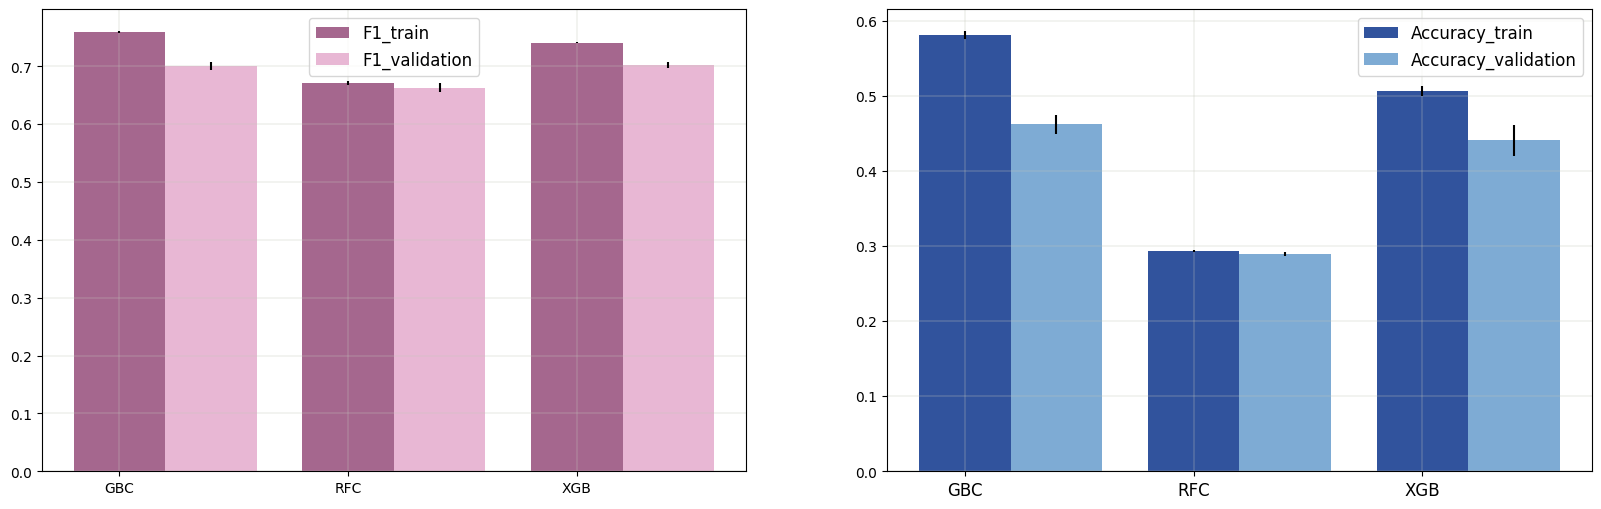

In [19]:
import matplotlib.patches as mpatches

barWidth = 0.4

br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
br3 =  np.arange(3)
br4 = [x + barWidth for x in br3]

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(20, 6))

ax1.bar(br1, df_error_train_1['F1_train_mean'], color =colors[0], width = barWidth, label ='F1_train', yerr = df_error_train_1['F1_train_std'])
ax1.bar(br2, df_error_train_1['F1_test_mean'], color =colors[1], width = barWidth, label ='F1_validation', yerr = df_error_train_1['F1_test_std'])

ax2.bar(br3, df_error_train_1['Accuracy_train_mean'], color =colors[4], width = barWidth, label ='Accuracy_train', yerr = df_error_train_1['Accuracy_train_std'])
ax2.bar(br4, df_error_train_1['Accuracy_test_mean'], color =colors[3], width = barWidth, label ='Accuracy_validation', yerr = df_error_train_1['Accuracy_test_std'])

plt.xticks(br1, ['GBC','RFC','XGB'], fontsize = 12)

ax1.grid(color='#C3C6BA', linewidth=0.3)
ax2.grid(color='#C3C6BA', linewidth=0.3)


ax1.legend(fontsize = 12)
ax2.legend(fontsize = 12)


In [13]:
import joblib
joblib.dump(class_GBC, 'strength.pkl')

['strength.pkl']